# 📊 Market Data Collection & Exploratory Data Analysis

This notebook collects historical price data for a **selectable ticker**, performs EDA, engineers 28+ technical-indicator features, and saves everything ready for model training.

**To switch stocks** – just change the `TICKER` variable in the cell below.

In [ ]:
# Install required packages (safe to re-run)
!pip install yfinance pandas numpy matplotlib seaborn scikit-learn joblib plotly -q

In [ ]:
import pandas  as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime  import datetime, timedelta
import os, warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
print("✓ Libraries imported")

✓ Libraries imported


## 🎯 Step 1 – Pick Your Ticker

Change `TICKER` below to any of the supported symbols (or any valid Yahoo Finance ticker).

| Symbol | Company |
|--------|---------|
| AAPL | Apple |
| TSLA | Tesla |
| GOOGL | Alphabet |
| MSFT | Microsoft |
| AMZN | Amazon |
| NVDA | NVIDIA |
| META | Meta |
| JPM | JPMorgan |
| V | Visa |
| JNJ | Johnson & Johnson |

In [ ]:
# ───────────────────────────────────────────
# 👇  CHANGE THIS to switch stocks
# ───────────────────────────────────────────
TICKER = "AAPL"

# date range
START_DATE = "2020-01-01"
END_DATE   = datetime.now().strftime("%Y-%m-%d")

# derived paths (auto-set from ticker – don't edit)
RAW_PATH       = f"data/{TICKER}_raw_market_data.csv"
PROCESSED_PATH = f"data/{TICKER}_processed_market_data.csv"

print(f"📊 Ticker : {TICKER}")
print(f"📅 Range  : {START_DATE}  →  {END_DATE}")
print(f"💾 Raw    : {RAW_PATH}")
print(f"💾 Proc   : {PROCESSED_PATH}")

📊 Ticker : AAPL
📅 Range  : 2020-01-01  →  2026-02-03
💾 Raw    : data/AAPL_raw_market_data.csv
💾 Proc   : data/AAPL_processed_market_data.csv


## 📥 Step 2 – Data Collection

In [ ]:
print(f"Fetching {TICKER} data …")
df = yf.download(TICKER, start=START_DATE, end=END_DATE)

# flatten MultiIndex columns that yfinance sometimes returns
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

print(f"✓ Fetched {len(df)} rows")
df.head()

Fetching AAPL data …


[*********************100%***********************]  1 of 1 completed

✓ Fetched 1529 rows


Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,72.468277,72.528597,71.223274,71.476615,135480400
2020-01-03,71.763725,72.523754,71.539337,71.696167,146322800
2020-01-06,72.335548,72.374154,70.634532,70.885464,118387200
2020-01-07,71.995346,72.600952,71.775781,72.345197,108872000
2020-01-08,73.153481,73.455080,71.698566,71.698566,132079200


In [ ]:
os.makedirs("data", exist_ok=True)
df.to_csv(RAW_PATH)
print(f"✓ Raw data saved → {RAW_PATH}")

✓ Raw data saved → data/AAPL_raw_market_data.csv


## 🔍 Step 3 – Exploratory Data Analysis

In [ ]:
print("Shape :", df.shape)
print("\n" + "="*50)
df.describe()

Shape : (1529, 5)



Price,Close,High,Low,Open,Volume
count,1529.000000,1529.000000,1529.000000,1529.000000,1.529000e+03
mean,166.223015,167.922260,164.358137,166.065080,8.410474e+07
std,50.562202,50.872139,50.206047,50.525974,5.117186e+07
min,54.264328,55.263178,51.420150,55.161600,1.791060e+07
25%,131.973129,133.523281,130.286594,132.126656,5.041930e+07
50%,164.424362,166.307322,162.983412,164.560302,6.988650e+07
75%,200.577713,202.816452,198.841351,200.926977,9.962530e+07
max,286.190002,288.619995,283.299988,286.200012,4.265100e+08


In [ ]:
missing = df.isnull().sum()
print("Missing values:\n", missing[missing > 0] if missing.sum() else "None ✓")

Missing values:
 None ✓


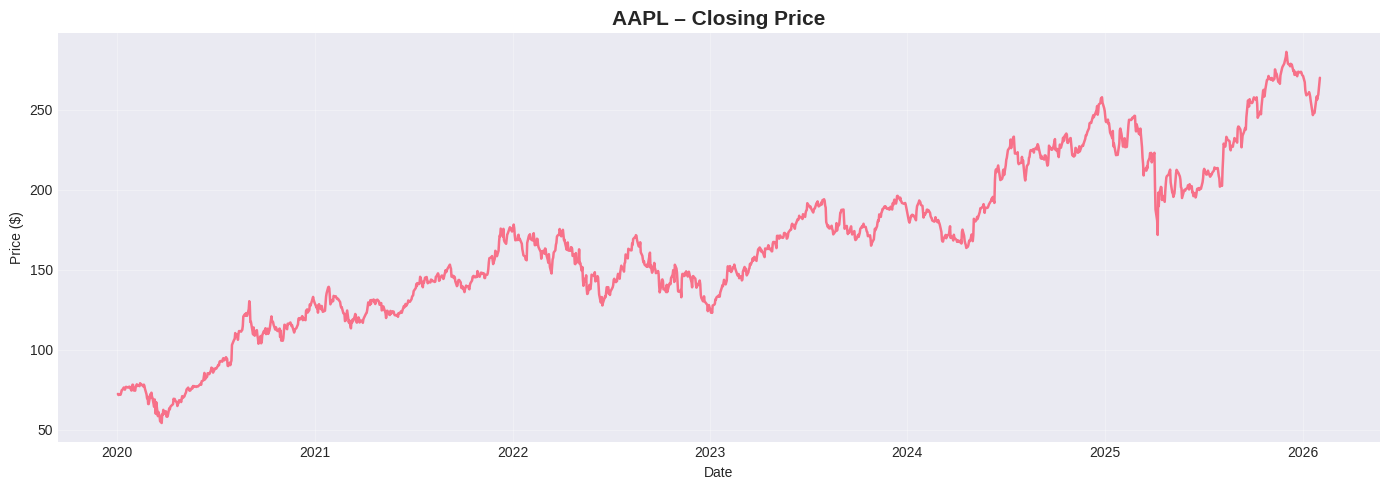

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(df.index, df["Close"], linewidth=1.8)
plt.title(f"{TICKER} – Closing Price", fontsize=15, fontweight="bold")
plt.xlabel("Date"); plt.ylabel("Price ($)")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

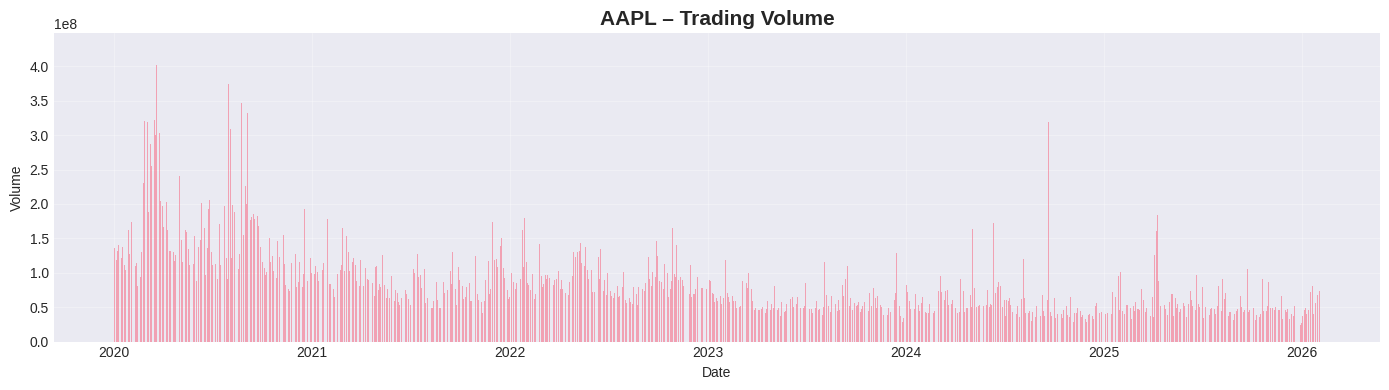

In [ ]:
plt.figure(figsize=(14, 4))
plt.bar(df.index, df["Volume"], alpha=0.6)
plt.title(f"{TICKER} – Trading Volume", fontsize=15, fontweight="bold")
plt.xlabel("Date"); plt.ylabel("Volume")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

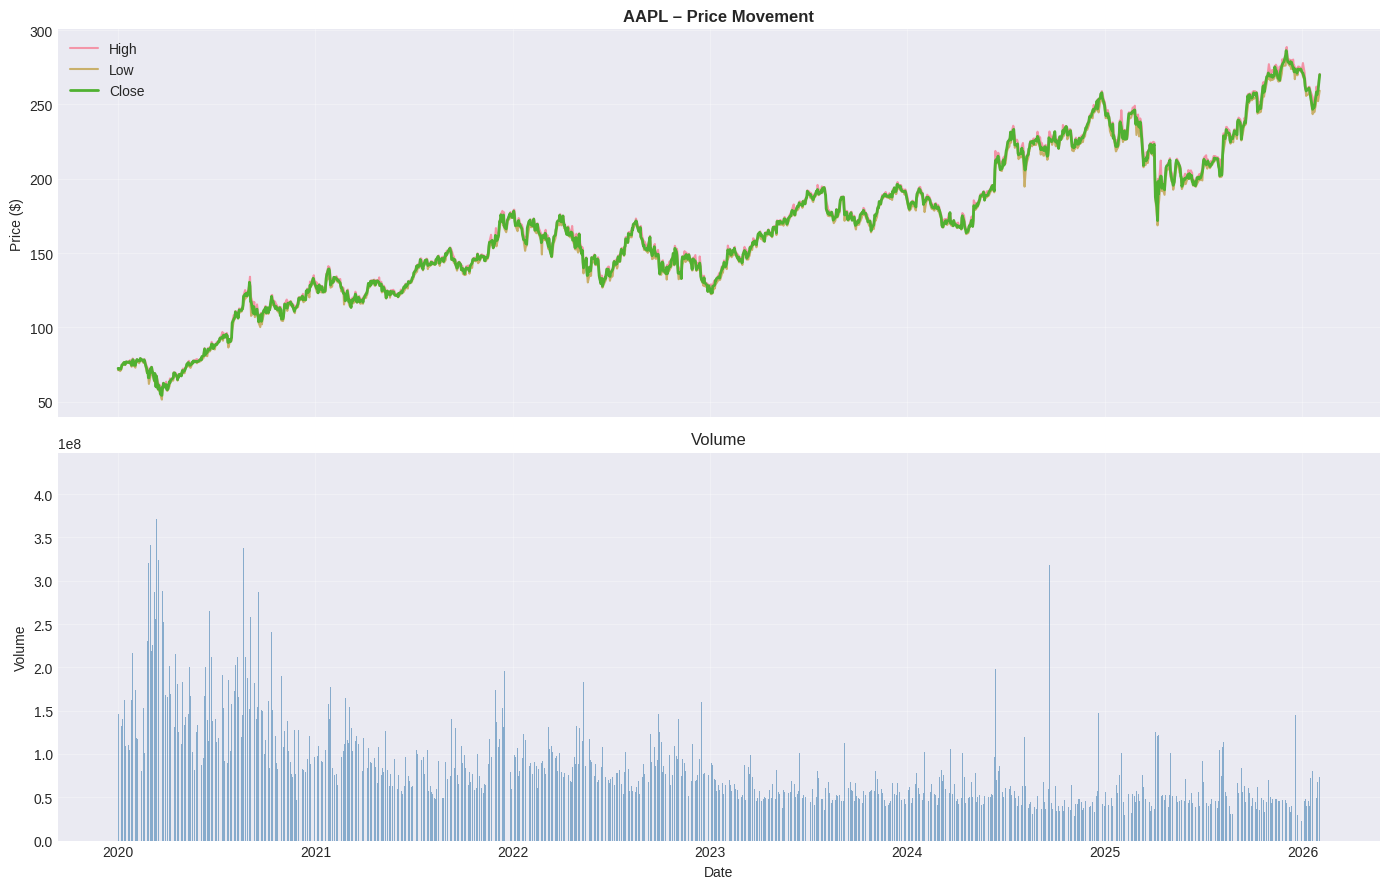

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9), sharex=True)

ax1.plot(df.index, df["High"],  label="High",  alpha=0.7)
ax1.plot(df.index, df["Low"],   label="Low",   alpha=0.7)
ax1.plot(df.index, df["Close"], label="Close", linewidth=2)
ax1.fill_between(df.index, df["Low"].values, df["High"].values, alpha=0.15)
ax1.set_title(f"{TICKER} – Price Movement", fontweight="bold")
ax1.set_ylabel("Price ($)"); ax1.legend(); ax1.grid(alpha=0.3)

ax2.bar(df.index, df["Volume"], alpha=0.6, color="steelblue")
ax2.set_title("Volume"); ax2.set_xlabel("Date")
ax2.set_ylabel("Volume"); ax2.grid(alpha=0.3)
plt.tight_layout(); plt.show()

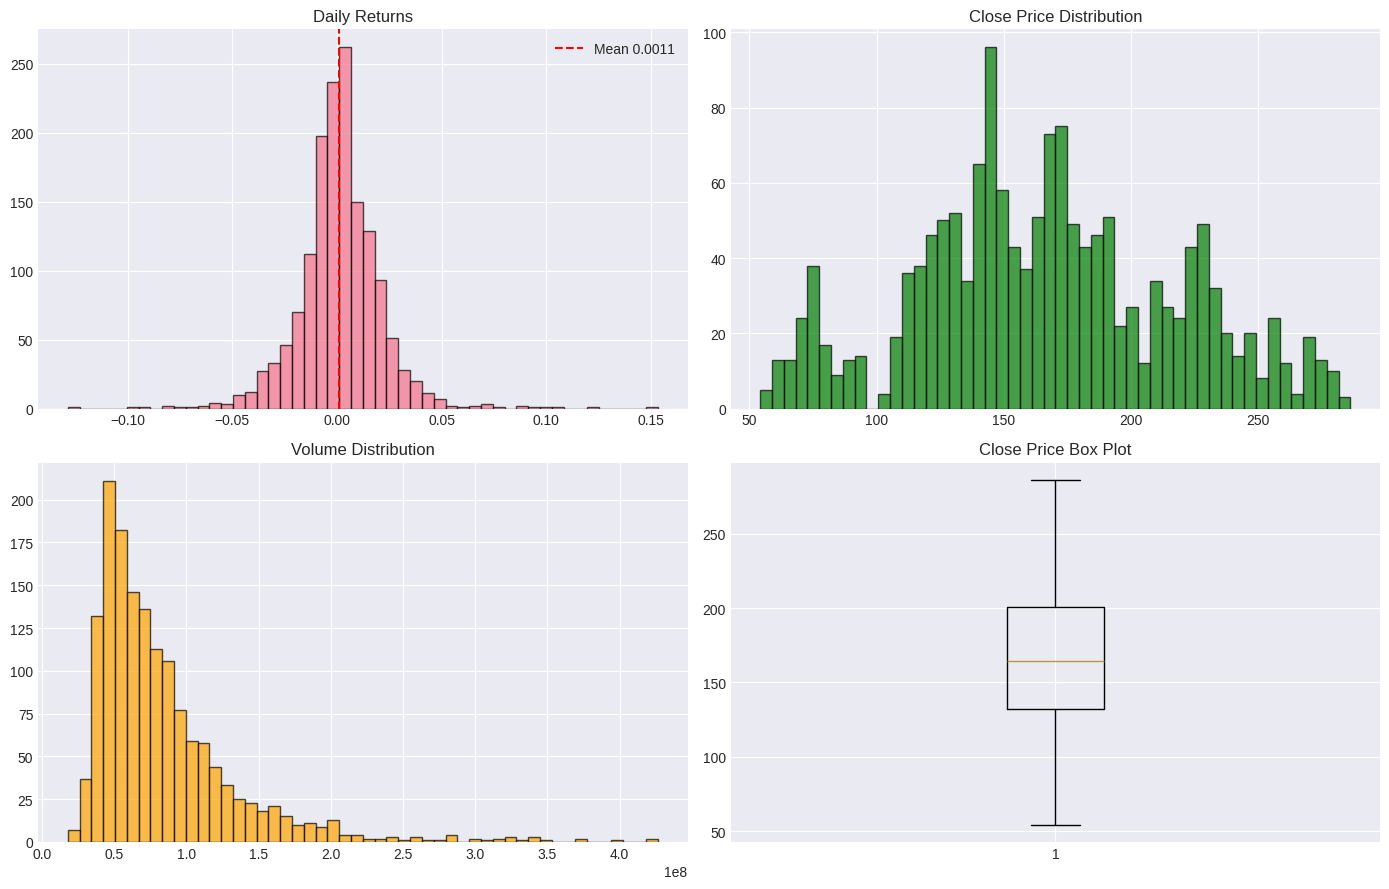

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 9))
daily_ret = df["Close"].pct_change().dropna()

axes[0,0].hist(daily_ret, bins=50, alpha=0.7, edgecolor="black")
axes[0,0].axvline(daily_ret.mean(), color="red", linestyle="--",
                  label=f"Mean {daily_ret.mean():.4f}")
axes[0,0].set_title("Daily Returns"); axes[0,0].legend()

axes[0,1].hist(df["Close"], bins=50, alpha=0.7, color="green", edgecolor="black")
axes[0,1].set_title("Close Price Distribution")

axes[1,0].hist(df["Volume"], bins=50, alpha=0.7, color="orange", edgecolor="black")
axes[1,0].set_title("Volume Distribution")

axes[1,1].boxplot(df["Close"])
axes[1,1].set_title("Close Price Box Plot")
plt.tight_layout(); plt.show()

In [ ]:
print(f"Current Price   : ${df['Close'].iloc[-1]:.2f}")
print(f"52-Week High    : ${df['High'].tail(252).max():.2f}")
print(f"52-Week Low     : ${df['Low'].tail(252).min():.2f}")
print(f"Avg Vol (30 d)  : {df['Volume'].tail(30).mean():,.0f}")
print(f"Mean Daily Ret  : {daily_ret.mean():.4f}")
print(f"Std  Daily Ret  : {daily_ret.std():.4f}")

Current Price   : $270.01
52-Week High    : $288.62
52-Week Low     : $168.63
Avg Vol (30 d)  : 49,629,750
Mean Daily Ret  : 0.0011
Std  Daily Ret  : 0.0200


## ⚙️ Step 4 – Feature Engineering
Creating technical indicators used by the model.

In [ ]:
d = df.copy()

# Moving Averages
d["MA_5"]  = d["Close"].rolling(5).mean()
d["MA_10"] = d["Close"].rolling(10).mean()
d["MA_20"] = d["Close"].rolling(20).mean()
d["MA_50"] = d["Close"].rolling(50).mean()

# Exponential MAs
d["EMA_12"] = d["Close"].ewm(span=12, adjust=False).mean()
d["EMA_26"] = d["Close"].ewm(span=26, adjust=False).mean()

# MACD
d["MACD"]        = d["EMA_12"] - d["EMA_26"]
d["MACD_Signal"] = d["MACD"].ewm(span=9, adjust=False).mean()

# RSI
delta = d["Close"].diff()
gain  = delta.where(delta > 0, 0).rolling(14).mean()
loss  = (-delta.where(delta < 0, 0)).rolling(14).mean()
d["RSI"] = 100 - (100 / (1 + gain / loss))

# Bollinger Bands
d["BB_Middle"] = d["Close"].rolling(20).mean()
bb_std         = d["Close"].rolling(20).std()
d["BB_Upper"]  = d["BB_Middle"] + bb_std * 2
d["BB_Lower"]  = d["BB_Middle"] - bb_std * 2

# Price features
d["Daily_Return"] = d["Close"].pct_change()
d["Price_Range"]  = d["High"] - d["Low"]
d["Price_Change"] = d["Close"] - d["Open"]

# Volume features
d["Volume_MA_5"]  = d["Volume"].rolling(5).mean()
d["Volume_Ratio"] = d["Volume"] / d["Volume_MA_5"]

# Volatility
d["Volatility"] = d["Daily_Return"].rolling(20).std()

# Lag features
for i in [1, 2, 3, 5, 7]:
    d[f"Close_Lag_{i}"]  = d["Close"].shift(i)
    d[f"Volume_Lag_{i}"] = d["Volume"].shift(i)

# Target (next-day close)
d["Target"] = d["Close"].shift(-1)

df_features = d
print(f"✓ {len(df_features.columns)} columns created")
print("New features:", [c for c in df_features.columns if c not in df.columns])

✓ 34 columns created
New features: ['MA_5', 'MA_10', 'MA_20', 'MA_50', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'Daily_Return', 'Price_Range', 'Price_Change', 'Volume_MA_5', 'Volume_Ratio', 'Volatility', 'Close_Lag_1', 'Volume_Lag_1', 'Close_Lag_2', 'Volume_Lag_2', 'Close_Lag_3', 'Volume_Lag_3', 'Close_Lag_5', 'Volume_Lag_5', 'Close_Lag_7', 'Volume_Lag_7', 'Target']


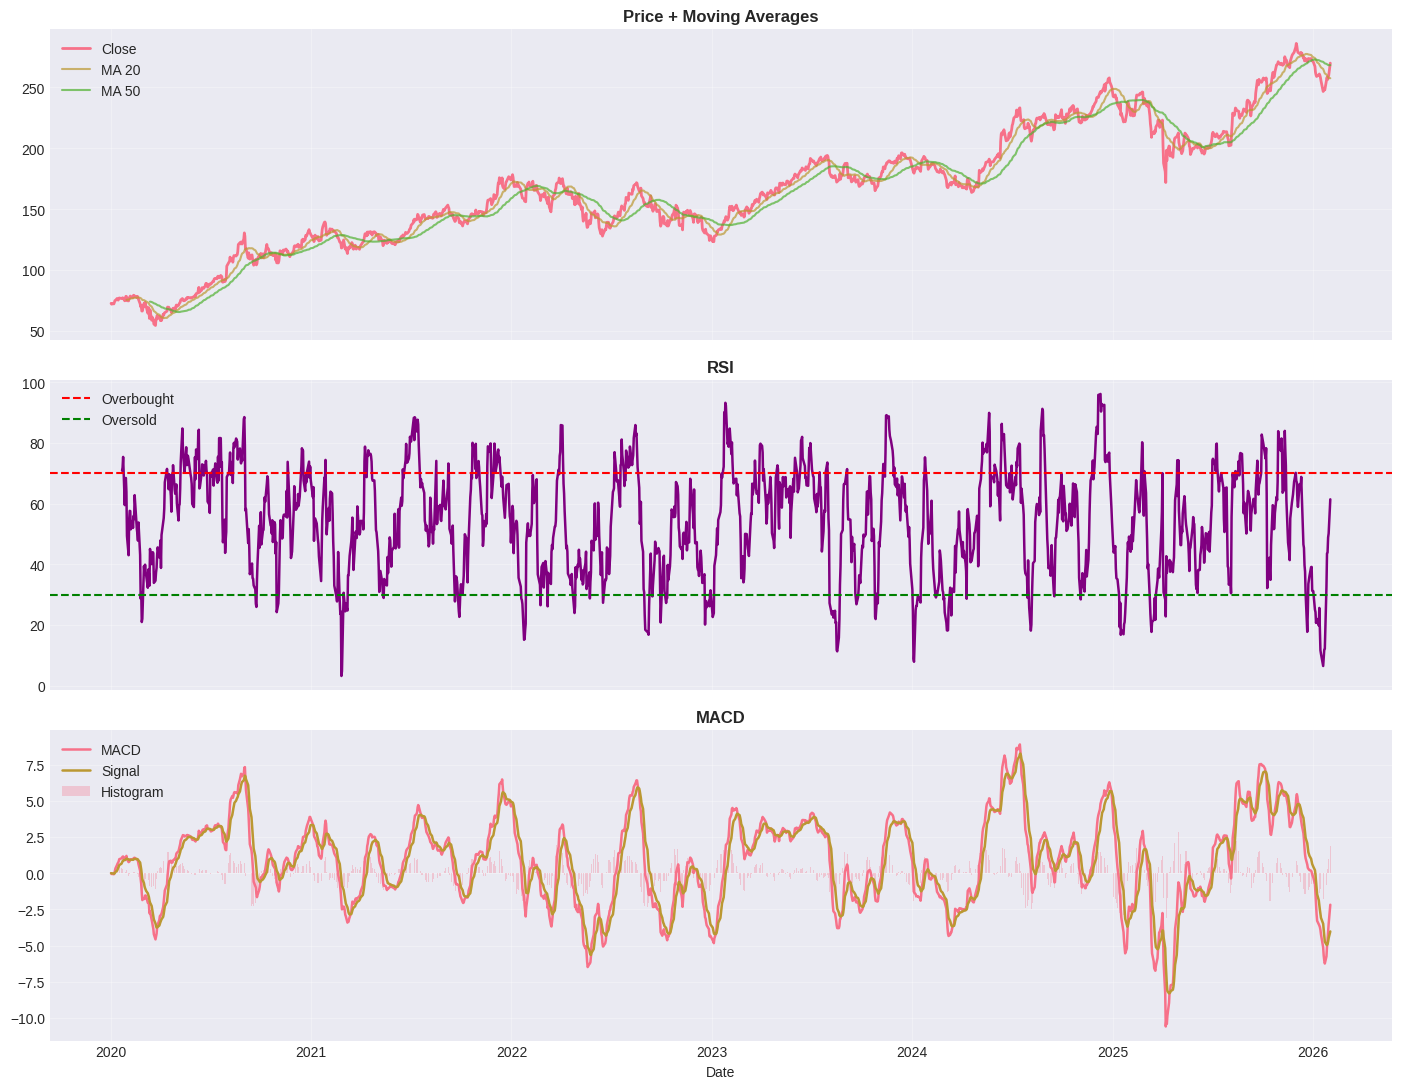

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 11), sharex=True)

axes[0].plot(df_features.index, df_features["Close"], label="Close", linewidth=2)
axes[0].plot(df_features.index, df_features["MA_20"], label="MA 20", alpha=0.7)
axes[0].plot(df_features.index, df_features["MA_50"], label="MA 50", alpha=0.7)
axes[0].set_title("Price + Moving Averages", fontweight="bold")
axes[0].legend(); axes[0].grid(alpha=0.3)

axes[1].plot(df_features.index, df_features["RSI"], color="purple", linewidth=1.8)
axes[1].axhline(70, color="red",   linestyle="--", label="Overbought")
axes[1].axhline(30, color="green", linestyle="--", label="Oversold")
axes[1].set_title("RSI", fontweight="bold")
axes[1].legend(); axes[1].grid(alpha=0.3)

axes[2].plot(df_features.index, df_features["MACD"],        label="MACD", linewidth=1.8)
axes[2].plot(df_features.index, df_features["MACD_Signal"], label="Signal", linewidth=1.8)
axes[2].bar(df_features.index, df_features["MACD"]-df_features["MACD_Signal"],
            label="Histogram", alpha=0.3)
axes[2].set_title("MACD", fontweight="bold")
axes[2].set_xlabel("Date"); axes[2].legend(); axes[2].grid(alpha=0.3)
plt.tight_layout(); plt.show()

## 🧹 Step 5 – Clean & Save

Rows: 1529 → 1479  (50 dropped)


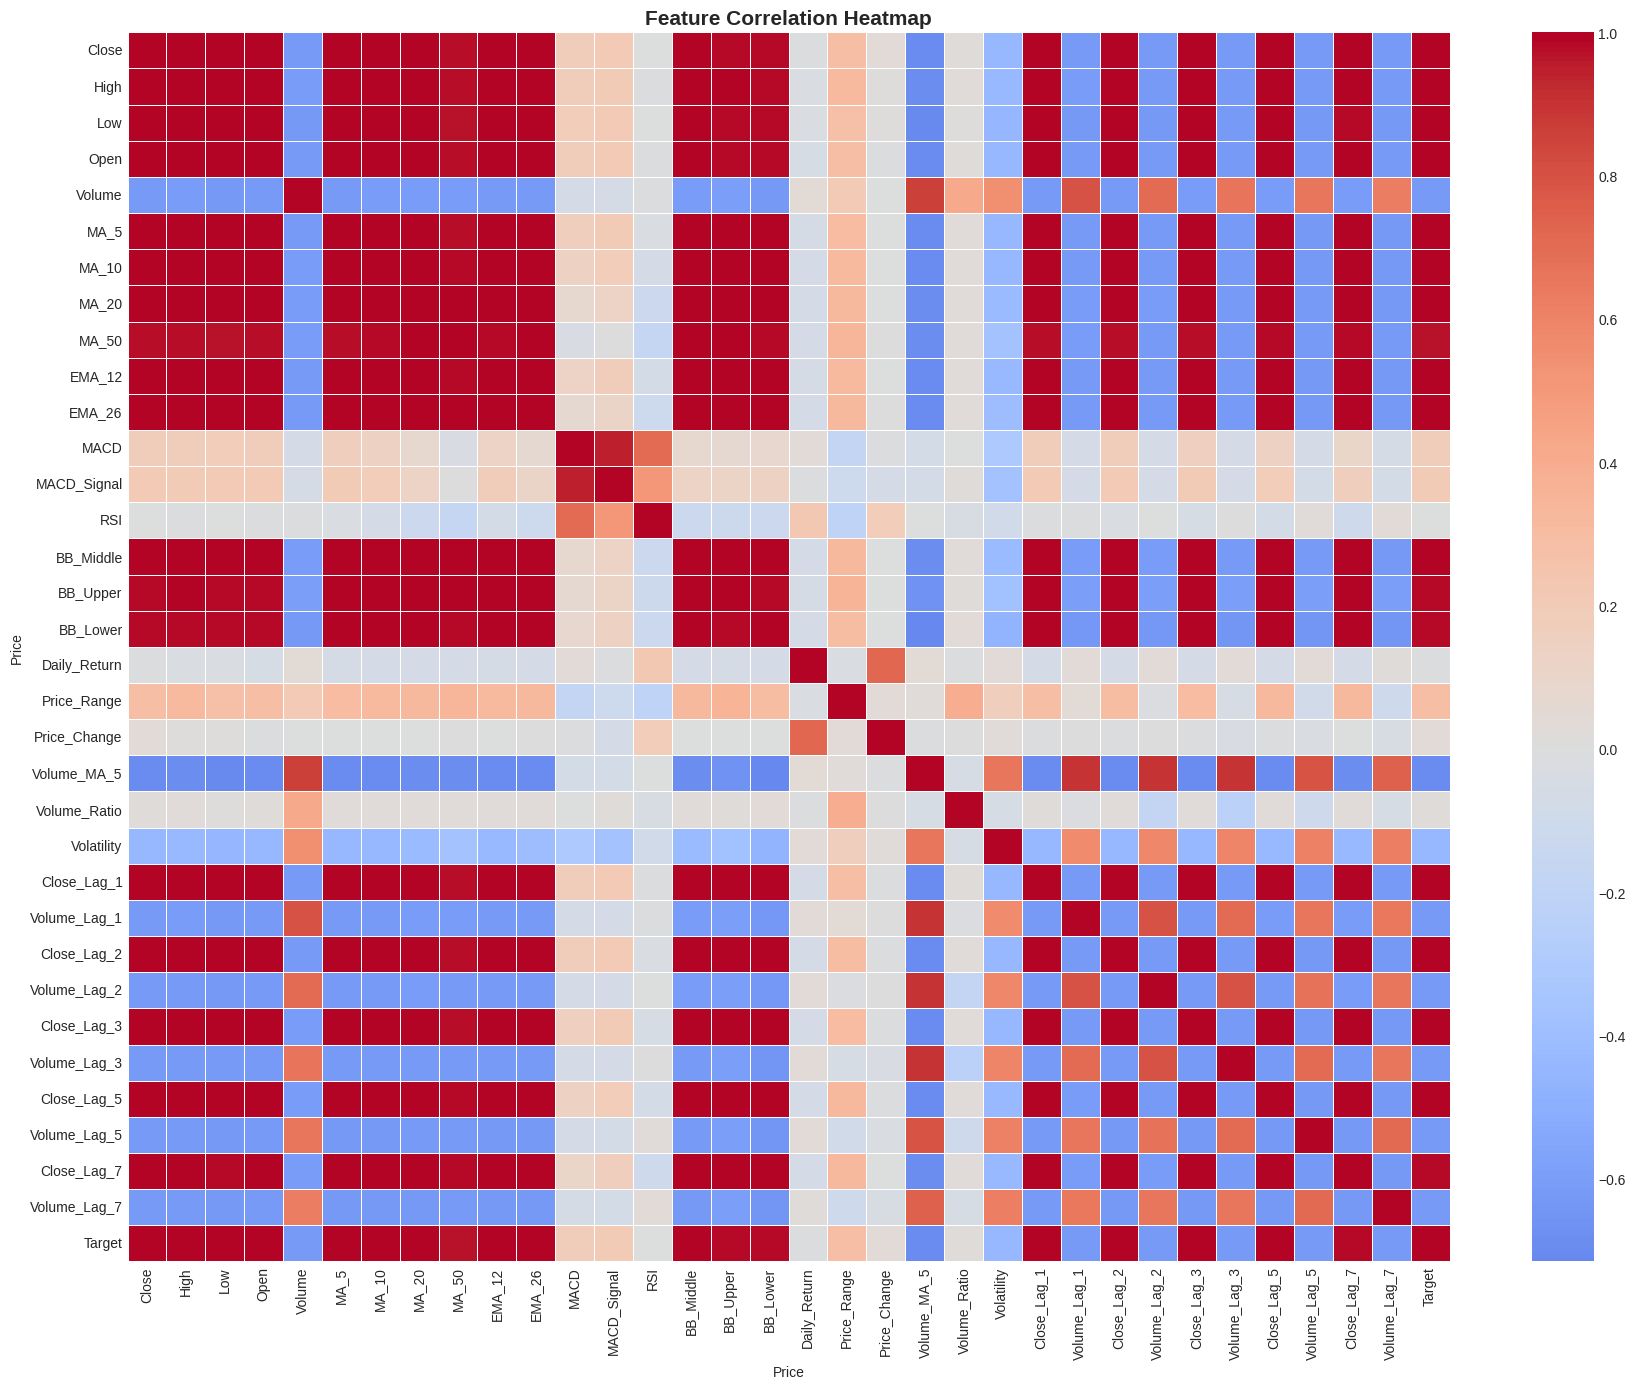


Top correlations with Target:
Price
Close          0.998053
Low            0.997494
High           0.997487
Open           0.996733
Close_Lag_1    0.995998
MA_5           0.995564
Close_Lag_2    0.993851
EMA_12         0.993573
MA_10          0.992735
Close_Lag_3    0.991891
Name: Target, dtype: float64


In [ ]:
df_clean = df_features.dropna()
print(f"Rows: {len(df_features)} → {len(df_clean)}  ({len(df_features)-len(df_clean)} dropped)")

# correlation heatmap
numeric = df_clean.select_dtypes(include=[np.number])
plt.figure(figsize=(18, 14))
sns.heatmap(numeric.corr(), annot=False, cmap="coolwarm", center=0, linewidths=0.4)
plt.title("Feature Correlation Heatmap", fontsize=15, fontweight="bold")
plt.tight_layout(); plt.show()

print("\nTop correlations with Target:")
print(numeric.corr()["Target"].sort_values(ascending=False).head(11)[1:])

In [ ]:
df_clean.to_csv(PROCESSED_PATH)
print(f"✓ Processed data saved → {PROCESSED_PATH}")
print(f"  Samples  : {len(df_clean)}")
print(f"  Features : {len(df_clean.columns)}")
print(f"  Range    : {df_clean.index.min()} → {df_clean.index.max()}")
print("\n✓ Ready for notebook 02 – model building!")

✓ Processed data saved → data/AAPL_processed_market_data.csv
  Samples  : 1479
  Features : 34
  Range    : 2020-03-13 00:00:00 → 2026-01-30 00:00:00

✓ Ready for notebook 02 – model building!


# 🧠 Model Building & Evaluation

Train, compare and save the best model **for the ticker you chose in notebook 01**.

> Make sure you set the same `TICKER` value here as in the previous notebook.

In [18]:
!pip install xgboost lightgbm scikit-learn joblib -q

In [19]:
import pandas  as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, json, os, warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection  import GridSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics          import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model    import LinearRegression, Ridge, Lasso
from sklearn.ensemble        import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree            import DecisionTreeRegressor
import xgboost  as xgb
import lightgbm as lgb

print("✓ Libraries imported")

✓ Libraries imported


## 🎯 Step 1 – Match Your Ticker
Set `TICKER` to the **same value** you used in notebook 01.

In [20]:
# ───────────────────────────────────────────
# 👇  Must match notebook 01
# ───────────────────────────────────────────
TICKER = "AAPL"

# derived paths (auto-set – don't edit)
PROCESSED_PATH  = f"data/{TICKER}_processed_market_data.csv"
MODEL_PATH      = f"models/{TICKER}_model.pkl"
SCALER_PATH     = f"models/{TICKER}_scaler.pkl"
METADATA_PATH   = f"models/{TICKER}_model_metadata.json"

print(f"📊 Ticker   : {TICKER}")
print(f"📂 Data     : {PROCESSED_PATH}")
print(f"💾 Model    : {MODEL_PATH}")
print(f"💾 Scaler   : {SCALER_PATH}")
print(f"📝 Metadata : {METADATA_PATH}")

📊 Ticker   : AAPL
📂 Data     : data/AAPL_processed_market_data.csv
💾 Model    : models/AAPL_model.pkl
💾 Scaler   : models/AAPL_scaler.pkl
📝 Metadata : models/AAPL_model_metadata.json


## 📂 Step 2 – Load Processed Data

In [21]:
df = pd.read_csv(PROCESSED_PATH, index_col=0, parse_dates=True)
print(f"✓ Loaded {df.shape[0]} rows, {df.shape[1]} columns")
df.head()

✓ Loaded 1479 rows, 34 columns


,Close,High,Low,Open,Volume,MA_5,MA_10,MA_20,MA_50,EMA_12,...,Volume_Lag_1,Close_Lag_2,Volume_Lag_2,Close_Lag_3,Volume_Lag_3,Close_Lag_5,Volume_Lag_5,Close_Lag_7,Volume_Lag_7,Target
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-13,67.227608,67.699222,61.176469,64.064186,370732000,65.451930,68.346412,70.774000,73.870380,68.073783,...,418474000.0,66.613319,255598800.0,69.010056,285290000.0,69.902473,226176800.0,73.218277,219178400.0,58.578968
2020-03-16,58.578968,62.659006,58.044474,58.516084,322423600,64.292976,66.977528,69.773459,73.592594,66.613042,...,370732000.0,60.034927,418474000.0,66.613319,255598800.0,64.373741,286744800.0,70.843277,187572800.0,61.154686
2020-03-17,61.154686,62.303479,57.657505,59.860777,324056000,62.721902,66.095733,68.973654,73.380413,65.773295,...,322423600.0,67.227608,370732000.0,60.034927,418474000.0,69.010056,285290000.0,69.902473,226176800.0,59.657642
2020-03-18,59.657642,60.463010,57.347955,57.988865,300233600,61.330766,64.739670,68.043128,73.126855,64.832426,...,324056000.0,58.578968,322423600.0,67.227608,370732000.0,66.613319,255598800.0,64.373741,286744800.0,59.200535
2020-03-19,59.200535,61.149861,58.675716,59.831769,271857200,61.163888,63.575396,67.129896,72.870959,63.965981,...,300233600.0,61.154686,324056000.0,58.578968,322423600.0,60.034927,418474000.0,69.010056,285290000.0,55.442150


## ⚙️ Step 3 – Feature Selection

In [22]:
exclude = ["Open", "High", "Low", "Close", "Volume", "Adj Close", "Target"]
feature_cols = [c for c in df.columns if c not in exclude]

X = df[feature_cols].replace([np.inf, -np.inf], np.nan).dropna()
y = df.loc[X.index, "Target"]

print(f"Features : {len(feature_cols)}")
print(f"X shape  : {X.shape}")
print(f"y shape  : {y.shape}")
print("Feature list:", feature_cols)

Features : 28
X shape  : (1479, 28)
y shape  : (1479,)
Feature list: ['MA_5', 'MA_10', 'MA_20', 'MA_50', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'Daily_Return', 'Price_Range', 'Price_Change', 'Volume_MA_5', 'Volume_Ratio', 'Volatility', 'Close_Lag_1', 'Volume_Lag_1', 'Close_Lag_2', 'Volume_Lag_2', 'Close_Lag_3', 'Volume_Lag_3', 'Close_Lag_5', 'Volume_Lag_5', 'Close_Lag_7', 'Volume_Lag_7']


## ✂️ Step 4 – Train / Test Split (temporal)

In [23]:
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

print(f"Train : {len(X_train)} samples  ({X_train.index.min()} → {X_train.index.max()})")
print(f"Test  : {len(X_test)}  samples  ({X_test.index.min()} → {X_test.index.max()})")

Train : 1183 samples  (2020-03-13 00:00:00 → 2024-11-21 00:00:00)
Test  : 296  samples  (2024-11-22 00:00:00 → 2026-01-30 00:00:00)


## 📐 Step 5 – Feature Scaling

In [24]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

os.makedirs("models", exist_ok=True)
joblib.dump(scaler, SCALER_PATH)
print(f"✓ Scaler saved → {SCALER_PATH}")

✓ Scaler saved → models/AAPL_scaler.pkl


## 🤖 Step 6 – Train & Compare Models

In [26]:
models = {
    "Linear Regression"   : LinearRegression(),
    "Ridge Regression"    : Ridge(alpha=1.0),
    "Lasso Regression"    : Lasso(alpha=1.0),
    "Decision Tree"       : DecisionTreeRegressor(random_state=42, max_depth=10),
    "Random Forest"       : RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    "Gradient Boosting"   : GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5),
    "XGBoost"             : xgb.XGBRegressor(n_estimators=100, random_state=42, max_depth=5, learning_rate=0.1),
    "LightGBM"            : lgb.LGBMRegressor(n_estimators=100, random_state=42, max_depth=5, learning_rate=0.1, verbose=-1),
}
print(f"Models to train: {len(models)}")

Models to train: 8


In [27]:
results, trained = [], {}

for name, model in models.items():
    print(f"  Training {name} …", end=" ")
    model.fit(X_train_sc, y_train)
    tr_pred = model.predict(X_train_sc)
    te_pred = model.predict(X_test_sc)

    res = {
        "Model"      : name,
        "Train RMSE" : np.sqrt(mean_squared_error(y_train, tr_pred)),
        "Test RMSE"  : np.sqrt(mean_squared_error(y_test,  te_pred)),
        "Train MAE"  : mean_absolute_error(y_train, tr_pred),
        "Test MAE"   : mean_absolute_error(y_test,  te_pred),
        "Train R²"   : r2_score(y_train, tr_pred),
        "Test R²"    : r2_score(y_test,  te_pred),
        "Predictions": te_pred,
    }
    results.append(res)
    trained[name] = model
    print(f"RMSE ${res['Test RMSE']:.2f}  |  R² {res['Test R²']:.4f}")

print("\n✓ All models trained")

  Training Linear Regression … RMSE $4.30  |  R² 0.9720
  Training Ridge Regression … RMSE $4.60  |  R² 0.9680
  Training Lasso Regression … RMSE $5.86  |  R² 0.9481
  Training Decision Tree … RMSE $24.52  |  R² 0.0898
  Training Random Forest … RMSE $23.72  |  R² 0.1482
  Training Gradient Boosting … RMSE $24.77  |  R² 0.0714
  Training XGBoost … RMSE $25.49  |  R² 0.0163
  Training LightGBM … RMSE $24.22  |  R² 0.1121

✓ All models trained


## 📊 Step 7 – Model Comparison

In [28]:
results_df = pd.DataFrame(results)
compare    = results_df.drop("Predictions", axis=1).sort_values("Test RMSE")
print(compare.to_string(index=False))

best_name = compare.iloc[0]["Model"]
print(f"\n⭐ Best model : {best_name}")

            Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  Test R²
Linear Regression    2.657217   4.303788   1.991646  2.910769  0.995031 0.971966
 Ridge Regression    2.723586   4.597140   2.053083  3.089969  0.994780 0.968014
 Lasso Regression    3.213697   5.858621   2.471834  4.430791  0.992732 0.948052
    Random Forest    1.271808  23.723753   0.954098 18.447883  0.998862 0.148183
         LightGBM    1.576993  24.220876   1.192986 18.688415  0.998250 0.112110
    Decision Tree    0.849758  24.523826   0.489201 19.312011  0.999492 0.089760
Gradient Boosting    1.027661  24.770493   0.798348 19.360944  0.999257 0.071357
          XGBoost    1.138607  25.494367   0.869821 19.109421  0.999088 0.016288

⭐ Best model : Linear Regression


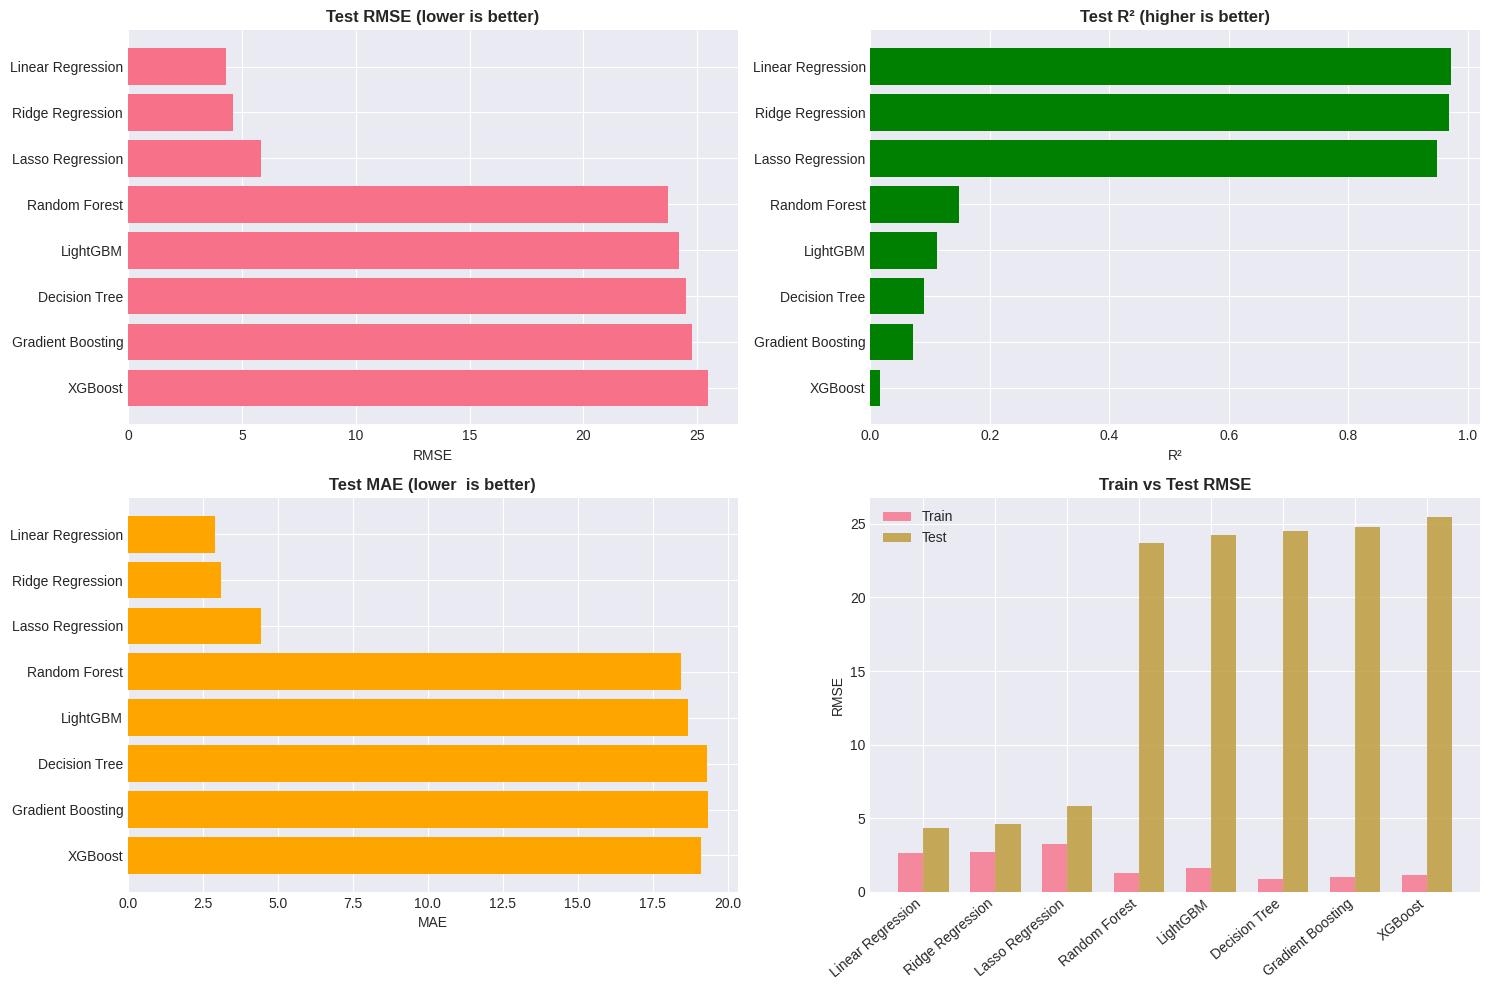

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].barh(compare["Model"], compare["Test RMSE"])
axes[0,0].set_xlabel("RMSE"); axes[0,0].set_title("Test RMSE (lower is better)", fontweight="bold"); axes[0,0].invert_yaxis()

axes[0,1].barh(compare["Model"], compare["Test R²"], color="green")
axes[0,1].set_xlabel("R²");   axes[0,1].set_title("Test R² (higher is better)", fontweight="bold"); axes[0,1].invert_yaxis()

axes[1,0].barh(compare["Model"], compare["Test MAE"], color="orange")
axes[1,0].set_xlabel("MAE");  axes[1,0].set_title("Test MAE (lower  is better)", fontweight="bold"); axes[1,0].invert_yaxis()

x = np.arange(len(compare)); w = 0.35
axes[1,1].bar(x - w/2, compare["Train RMSE"], w, label="Train", alpha=0.8)
axes[1,1].bar(x + w/2, compare["Test RMSE"],  w, label="Test",  alpha=0.8)
axes[1,1].set_xticks(x); axes[1,1].set_xticklabels(compare["Model"], rotation=40, ha="right")
axes[1,1].set_ylabel("RMSE"); axes[1,1].set_title("Train vs Test RMSE", fontweight="bold"); axes[1,1].legend()

plt.tight_layout(); plt.show()

## 🏆 Step 8 – Best-Model Deep Dive

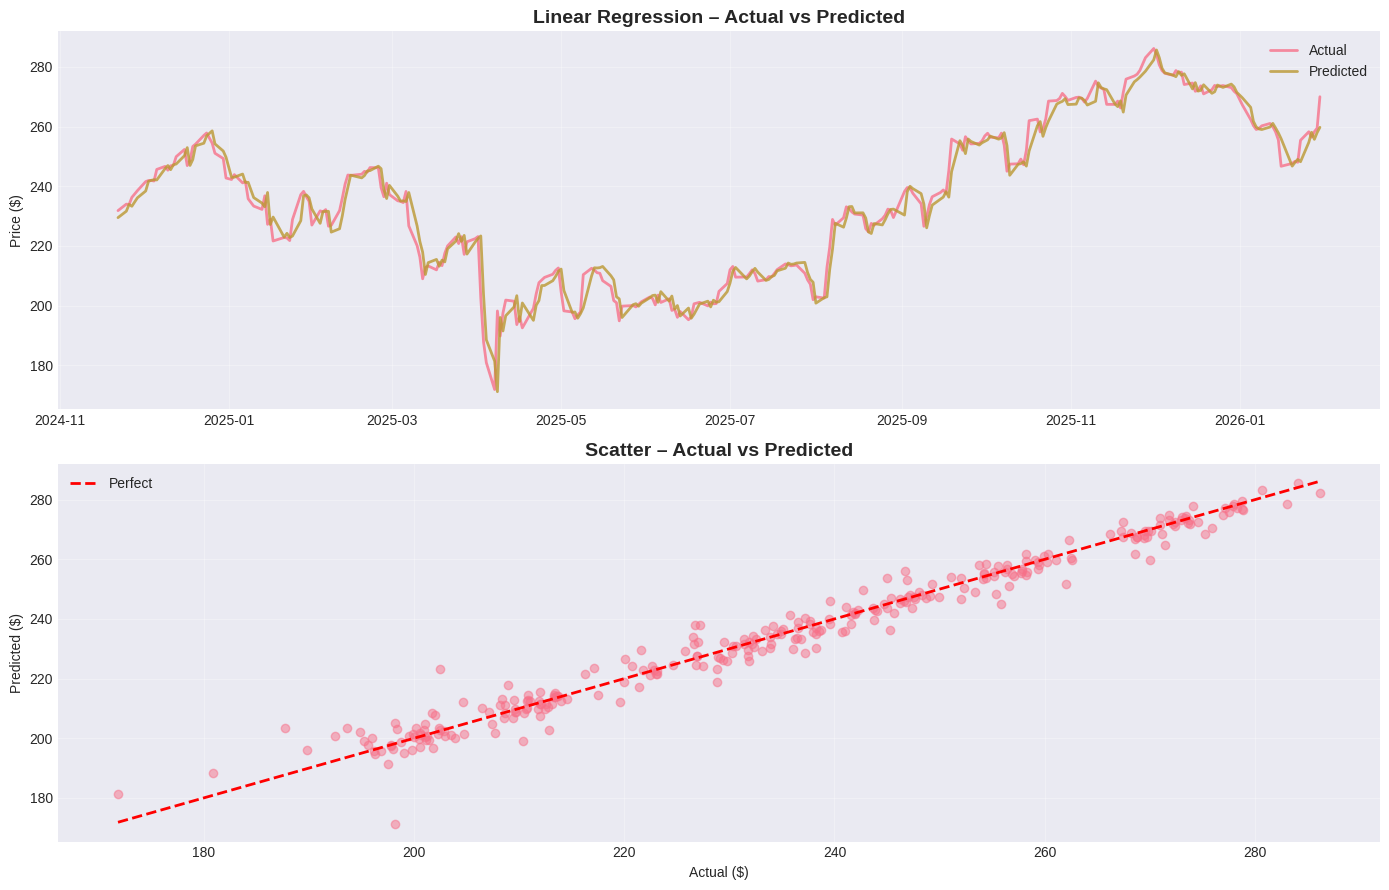

Test RMSE : $4.30
Test MAE  : $2.91
Test R²   : 0.9720


In [31]:
best_model = trained[best_name]
best_row   = results_df[results_df["Model"] == best_name].iloc[0]
y_pred     = best_row["Predictions"]

fig, axes = plt.subplots(2, 1, figsize=(14, 9))

axes[0].plot(y_test.index, y_test.values,  label="Actual",    linewidth=2, alpha=0.8)
axes[0].plot(y_test.index, y_pred,         label="Predicted", linewidth=2, alpha=0.8)
axes[0].set_title(f"{best_name} – Actual vs Predicted", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Price ($)"); axes[0].legend(); axes[0].grid(alpha=0.3)

axes[1].scatter(y_test, y_pred, alpha=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2, label="Perfect")
axes[1].set_xlabel("Actual ($)"); axes[1].set_ylabel("Predicted ($)")
axes[1].set_title("Scatter – Actual vs Predicted", fontsize=14, fontweight="bold")
axes[1].legend(); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()

print(f"Test RMSE : ${best_row['Test RMSE']:.2f}")
print(f"Test MAE  : ${best_row['Test MAE']:.2f}")
print(f"Test R²   : {best_row['Test R²']:.4f}")

## 🏆 Step 8 – Best-Model Deep Dive



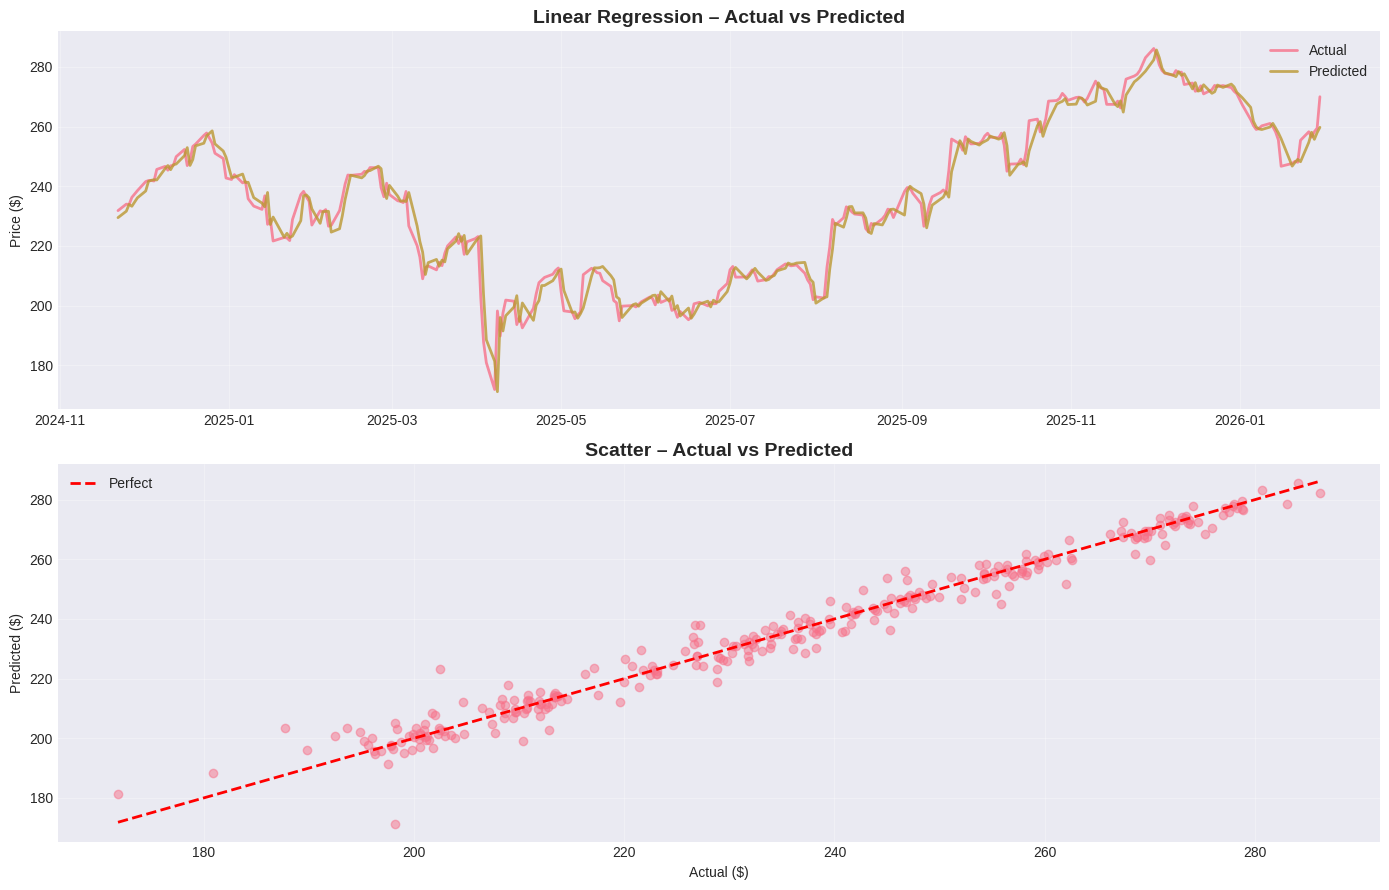

Test RMSE : $4.30
Test MAE  : $2.91
Test R²   : 0.9720


In [32]:
best_model = trained[best_name]
best_row   = results_df[results_df["Model"] == best_name].iloc[0]
y_pred     = best_row["Predictions"]

fig, axes = plt.subplots(2, 1, figsize=(14, 9))

axes[0].plot(y_test.index, y_test.values,  label="Actual",    linewidth=2, alpha=0.8)
axes[0].plot(y_test.index, y_pred,         label="Predicted", linewidth=2, alpha=0.8)
axes[0].set_title(f"{best_name} – Actual vs Predicted", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Price ($)"); axes[0].legend(); axes[0].grid(alpha=0.3)

axes[1].scatter(y_test, y_pred, alpha=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2, label="Perfect")
axes[1].set_xlabel("Actual ($)"); axes[1].set_ylabel("Predicted ($)")
axes[1].set_title("Scatter – Actual vs Predicted", fontsize=14, fontweight="bold")
axes[1].legend(); axes[1].grid(alpha=0.3)
plt.tight_layout(); plt.show()

print(f"Test RMSE : ${best_row['Test RMSE']:.2f}")
print(f"Test MAE  : ${best_row['Test MAE']:.2f}")
print(f"Test R²   : {best_row['Test R²']:.4f}")

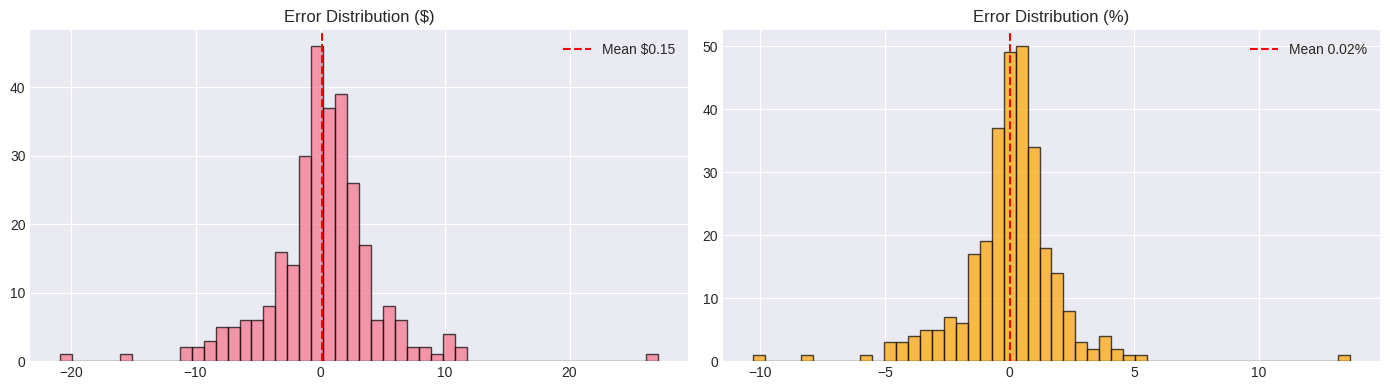

Mean Abs % Error : 1.29%


In [33]:
errors = y_test.values - y_pred
pct_err = (errors / y_test.values) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(errors, bins=50, edgecolor="black", alpha=0.7)
axes[0].axvline(errors.mean(), color="red", linestyle="--", label=f"Mean ${errors.mean():.2f}")
axes[0].set_title("Error Distribution ($)"); axes[0].legend()

axes[1].hist(pct_err, bins=50, edgecolor="black", alpha=0.7, color="orange")
axes[1].axvline(pct_err.mean(), color="red", linestyle="--", label=f"Mean {pct_err.mean():.2f}%")
axes[1].set_title("Error Distribution (%)"); axes[1].legend()

plt.tight_layout(); plt.show()
print(f"Mean Abs % Error : {np.abs(pct_err).mean():.2f}%")

## 📊 Step 9 – Feature Importance (tree models only)

In [34]:
if hasattr(best_model, "feature_importances_"):
    imp_df = pd.DataFrame({"Feature": X_train.columns, "Importance": best_model.feature_importances_})
    imp_df = imp_df.sort_values("Importance", ascending=False)

    plt.figure(figsize=(11, 7))
    top = imp_df.head(20)
    plt.barh(range(len(top)), top["Importance"])
    plt.yticks(range(len(top)), top["Feature"])
    plt.xlabel("Importance")
    plt.title(f"Top 20 Features – {best_name}", fontweight="bold")
    plt.gca().invert_yaxis(); plt.tight_layout(); plt.show()
    print(imp_df.head(10).to_string(index=False))
else:
    print(f"{best_name} does not expose feature_importances_.")

Linear Regression does not expose feature_importances_.


## 🔧 Step 10 – Hyperparameter Tuning (optional)
Skip this cell if you're happy with the default performance.

In [35]:
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200], "max_depth": [10, 15, 20], "min_samples_split": [2, 5]
    },
    "XGBoost": {
        "n_estimators": [100, 200], "max_depth": [5, 7, 10], "learning_rate": [0.01, 0.1]
    },
    "LightGBM": {
        "n_estimators": [100, 200], "max_depth": [5, 7, 10], "learning_rate": [0.01, 0.1]
    },
}

if best_name in param_grids:
    print(f"Grid search for {best_name} …")
    gs = GridSearchCV(best_model, param_grids[best_name],
                      cv=3, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
    gs.fit(X_train_sc, y_train)
    best_model = gs.best_estimator_

    te_pred_tuned = best_model.predict(X_test_sc)
    print(f"\n✓ Best params : {gs.best_params_}")
    print(f"  Tuned RMSE  : ${np.sqrt(mean_squared_error(y_test, te_pred_tuned)):.2f}")
    print(f"  Tuned R²    : {r2_score(y_test, te_pred_tuned):.4f}")
else:
    print(f"No tuning grid defined for {best_name} – using defaults.")

No tuning grid defined for Linear Regression – using defaults.


## 💾 Step 11 – Save Model + Metadata

In [36]:
# save model
joblib.dump(best_model, MODEL_PATH)
print(f"✓ Model saved   → {MODEL_PATH}")

# save metadata
metadata = {
    "model_name"       : best_name,
    "ticker"           : TICKER,
    "features"         : list(X_train.columns),
    "test_rmse"        : float(best_row["Test RMSE"]),
    "test_mae"         : float(best_row["Test MAE"]),
    "test_r2"          : float(best_row["Test R²"]),
    "train_date_range" : [str(X_train.index.min()), str(X_train.index.max())],
    "test_date_range"  : [str(X_test.index.min()),  str(X_test.index.max())],
    "training_date"    : str(pd.Timestamp.now()),
}

with open(METADATA_PATH, "w") as f:
    json.dump(metadata, f, indent=4)
print(f"✓ Metadata saved → {METADATA_PATH}")

print("\n" + "="*60)
print(f"  🎉  {TICKER} model pipeline complete!")
print(f"  Model : {best_name}   RMSE ${metadata['test_rmse']:.2f}   R² {metadata['test_r2']:.4f}")
print("="*60)
print("\nNext: run  monitor.py {ticker}  or open the Streamlit app.")

✓ Model saved   → models/AAPL_model.pkl
✓ Metadata saved → models/AAPL_model_metadata.json

  🎉  AAPL model pipeline complete!
  Model : Linear Regression   RMSE $4.30   R² 0.9720

Next: run  monitor.py {ticker}  or open the Streamlit app.
